# Building the Data Pipeline: 3D Patch Sampling

Deep learning models cannot ingest an entire 5GB CT scan at once. We must chop it into smaller 3D chunks (patches).

In this notebook, we will build a custom `ScrollDataset` that:
1.  Loads the large TIFF volumes.
2.  Randomly samples `(128, 128, 32)` patches during training.
3.  Normalizes the pixel intensities.

In [ ]:
import torch
import tifffile
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DATA_DIR = Path('data')
TRAIN_IMG = DATA_DIR / 'train_images'
TRAIN_LBL = DATA_DIR / 'train_labels'

## 1. The Dataset Class

We inherit from `torch.utils.data.Dataset`. 

**Critical Challenge**: Loading 800+ TIFF files for *every* patch is too slow (disk I/O bottleneck).
**Solution**: We define the "Dataset" as a *single* scroll volume. We load the whole volume into RAM (if it fits) or keep it memory-mapped. For this tutorial, we will load one volume into RAM (approx 300MB-1GB depending on size) for speed.

In [ ]:
class ScrollDataset(Dataset):
    def __init__(self, volume_path, label_path, patch_size=(32, 128, 128), samples_per_epoch=100):
        """
        Args:
            volume_path: Path to the 3D TIFF volume.
            label_path: Path to the 3D Label volume.
            patch_size: Tuple (Depth, Height, Width) e.g., (32, 128, 128).
            samples_per_epoch: Because we sample randomly, we define an arbitrary 'length' for the epoch.
        """
        print(f"Loading volume: {volume_path.name}...")
        self.volume = tifffile.imread(volume_path).astype(np.float32)
        self.label = tifffile.imread(label_path).astype(np.uint8) if label_path.exists() else None
        
        # Normalize Volume to 0-1 range (important for Neural Nets)
        self.volume = (self.volume - self.volume.min()) / (self.volume.max() - self.volume.min() + 1e-6)
        
        self.patch_size = patch_size
        self.samples = samples_per_epoch
        
        # Cached shape
        self.shape = self.volume.shape # (D, H, W)
        print(f"Volume loaded. Shape: {self.shape}")

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        # Random Crop Strategy
        # We pick a random coordinate (z, y, x) such that the patch fits inside
        D, H, W = self.shape
        d_crop, h_crop, w_crop = self.patch_size
        
        # Ensure crop fits
        z = np.random.randint(0, max(1, D - d_crop))
        y = np.random.randint(0, max(1, H - h_crop))
        x = np.random.randint(0, max(1, W - w_crop))
        
        # Extract Patch
        vol_patch = self.volume[z : z+d_crop, y : y+h_crop, x : x+w_crop]
        
        if self.label is not None:
            lbl_patch = self.label[z : z+d_crop, y : y+h_crop, x : x+w_crop]
        else:
            lbl_patch = np.zeros(vol_patch.shape, dtype=np.uint8)

        # PyTorch expects (Channel, Depth, Height, Width)
        # We add the Channel dimension using np.expand_dims
        return {
            'volume': torch.from_numpy(vol_patch).unsqueeze(0), # (1, D, H, W)
            'label': torch.from_numpy(lbl_patch).unsqueeze(0).float() # (1, D, H, W)
        }

## 2. Testing the Loader
Let's initialize the dataset with the first available scroll file and visualize a batch.

Loading volume: 1004283650.tif...
Volume loaded. Shape: (320, 320, 320)
Batch Shapes -> Volume: torch.Size([4, 1, 32, 128, 128]), Label: torch.Size([4, 1, 32, 128, 128])


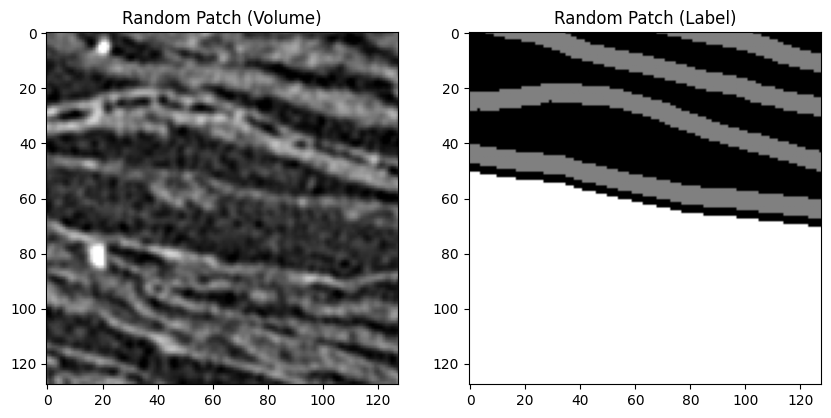

In [ ]:
files = sorted(list(TRAIN_IMG.glob('*.tif')))
if len(files) > 0:
    # Select one file for training
    img_path = files[0]
    lbl_path = TRAIN_LBL / img_path.name
    
    # Create Dataset
    dataset = ScrollDataset(img_path, lbl_path, patch_size=(32, 128, 128))
    
    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    # Get a batch
    batch = next(iter(dataloader))
    
    v = batch['volume']
    l = batch['label']
    
    print(f"Batch Shapes -> Volume: {v.shape}, Label: {l.shape}")
    
    # Visualise middle slice of the first sample in batch
    mid_z = 16
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(v[0, 0, mid_z, :, :], cmap='gray')
    ax[0].set_title("Random Patch (Volume)")
    ax[1].imshow(l[0, 0, mid_z, :, :], cmap='gray')
    ax[1].set_title("Random Patch (Label)")
    plt.show()